In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)

2021-07-31 15:39:22.687013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2021-07-31 15:39:22.687043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


2.5.0


In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, ZeroPadding2D,Activation, AveragePooling2D, Add, MaxPooling2D, GlobalAveragePooling2D, Layer, Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1,l2

In [21]:
warnings.filterwarnings('ignore')
dataset = tf.keras.preprocessing.image_dataset_from_directory('../dataset/sharma_59_nih_dataset/Image_dataset', image_size=(224, 224),
                                                             batch_size = 1)
dataset

Found 19459 files belonging to 2 classes.


<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [22]:
test_dataset = dataset.take(75*32)
train_dataset = dataset.skip(75*32)

valid_dataset = test_dataset.take(25*32)
test_dataset = test_dataset.skip(25*32)

train_dataset = train_dataset.take(300*32)
# train = 32 x 300 = 9600 images, test = 32 x 50 = 1600 images, valid = 32 x 25 = 800 images

# Image preprocessing

In [23]:
x_train = []
y_train = []
for a,b in train_dataset:
    x_train.append(a.numpy()[0])
    y_train.append(b.numpy()[0])
    
x_test = []
y_test = []
for a,b in test_dataset:
    x_test.append(a.numpy()[0])
    y_test.append(b.numpy()[0])

x_val = []
y_val = []
for a,b in valid_dataset:
    x_val.append(a.numpy()[0])
    y_val.append(b.numpy()[0])

In [24]:
x_train,x_test,x_val = np.array(x_train), np.array(x_test), np.array(x_val)

In [25]:
x_train.shape

(9600, 224, 224, 3)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_augmentation = ImageDataGenerator(rescale = 1/255.0, featurewise_center=True, 
                    featurewise_std_normalization=True, zoom_range=0.2,zca_whitening=True)
test_augmentation = ImageDataGenerator(rescale = 1/255.0, featurewise_center = True, featurewise_std_normalization=True)

# Training and testing

In [6]:
from tensorflow.keras import activations
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

      x_skip = x # this will be used for addition with the residual block 
      f1, f2 = filters

      #first block 
      x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
      x = BatchNormalization()(x)
      x = Activation(activations.relu)(x)

      #second block # bottleneck (but size kept same with padding)
      x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
      x = BatchNormalization()(x)
      x = Activation(activations.relu)(x)

      # third block activation used after adding the input
      x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
      x = BatchNormalization()(x)
      # x = Activation(activations.relu)(x)

      # add the input 
      x = Add()([x, x_skip])
      x = Activation(activations.relu)(x)

      return x

In [7]:

def res_conv(x, s, filters):
      '''
      here the input size changes''' 
      x_skip = x
      f1, f2 = filters

      # first block
      x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
      # when s = 2 then it is like downsizing the feature map
      x = BatchNormalization()(x)
      x = Activation(activations.relu)(x)

      # second block
      x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
      x = BatchNormalization()(x)
      x = Activation(activations.relu)(x)

      #third block
      x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
      x = BatchNormalization()(x)

      # shortcut 
      x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
      x_skip = BatchNormalization()(x_skip)

      # add 
      x = Add()([x, x_skip])
      x = Activation(activations.relu)(x)

      return x

In [13]:
def resnet50():

      input_im = Input(shape=(224,224,3)) # cifar 10 images size
      x = ZeroPadding2D(padding=(3, 3))(input_im)

      # 1st stage
      # here we perform maxpooling, see the figure above

      x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = MaxPooling2D((3, 3), strides=(2, 2))(x)

      #2nd stage 
      # frm here on only conv block and identity block, no pooling

      x = res_conv(x, s=1, filters=(64, 256))
      x = res_identity(x, filters=(64, 256))
      x = res_identity(x, filters=(64, 256))

      # 3rd stage

      x = res_conv(x, s=2, filters=(128, 512))
      x = res_identity(x, filters=(128, 512))
      x = res_identity(x, filters=(128, 512))
#       x = res_identity(x, filters=(128, 512))

      # 4th stage

      x = res_conv(x, s=2, filters=(256, 1024))
      x = res_identity(x, filters=(256, 1024))
      x = res_identity(x, filters=(256, 1024))
#       x = res_identity(x, filters=(256, 1024))

      # 5th stage

#       x = res_conv(x, s=2, filters=(512, 2048))
#       x = res_identity(x, filters=(512, 2048))
#       x = res_identity(x, filters=(512, 2048))

      # ends with average pooling and dense connection

      x = AveragePooling2D((2, 2), padding='same')(x)

      x = Flatten()(x)
      x = Dropout(0.4)(x)
      x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x) #multi-class

      # define the model 

      model = Model(inputs=input_im, outputs=x, name='Resnet50')

      return model

In [14]:
model = resnet50()
model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 112, 112, 64) 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 112, 112, 64) 256         conv2d_35[0][0]                  
___________________________________________________________________________________________

In [26]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

def scheduler(epoch, lr):
      if epoch < 10:
        return lr
      elif epoch % 5 ==0:
        return lr * tf.math.exp(-0.1)
      else:
        return lr

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_accuracy', restore_best_weights=True)

his = model.fit(train_augmentation.flow(x_train, y_train, batch_size=32),
         validation_data=test_augmentation.flow(x_val, y_val,
         batch_size=32),
         epochs=30, callbacks = [lrs, early_stop])

Epoch 1/30
300/300 [==============================] - 694s 2s/step - loss: 5.8998 - accuracy: 0.5350 - val_loss: 3.6024 - val_accuracy: 0.4000
Epoch 2/30
300/300 [==============================] - 676s 2s/step - loss: 3.2563 - accuracy: 0.5711 - val_loss: 3.2735 - val_accuracy: 0.6400
Epoch 3/30
300/300 [==============================] - 647s 2s/step - loss: 2.6348 - accuracy: 0.5472 - val_loss: 5.1940 - val_accuracy: 0.5200
Epoch 4/30
300/300 [==============================] - 670s 2s/step - loss: 2.2220 - accuracy: 0.5767 - val_loss: 1.6252 - val_accuracy: 0.4800
Epoch 5/30
300/300 [==============================] - 671s 2s/step - loss: 2.1119 - accuracy: 0.5815 - val_loss: 1.5547 - val_accuracy: 0.4800
Epoch 6/30
300/300 [==============================] - 663s 2s/step - loss: 2.2524 - accuracy: 0.5730 - val_loss: 1.7009 - val_accuracy: 0.4800
Epoch 7/30
300/300 [==============================] - 673s 2s/step - loss: 2.2686 - accuracy: 0.5727 - val_loss: 1.6010 - val_accuracy: 0.4800

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f02524421e0>
Traceback (most recent call last):
  File "/DATA/kumar156/.local/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/DATA/kumar156/.local/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 11/30
  5/300 [..............................] - ETA: 10:55 - loss: 1.6029 - accuracy: 0.5562

KeyboardInterrupt: 

In [27]:
loss, acc = model.evaluate(test_dataset)
acc

1600/1600 [==============================] - 63s 38ms/step - loss: 831.3813 - accuracy: 0.5031


0.503125011920929

In [28]:
loss, acc = model.evaluate(test_augmentation.flow(x_test,y_test, batch_size=32))
acc

50/50 [==============================] - 21s 414ms/step - loss: 1.4607 - accuracy: 0.5969


0.596875011920929

NameError: name 'his' is not defined

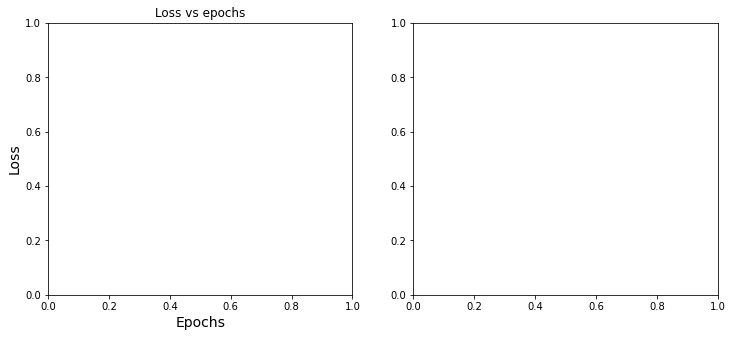

In [29]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(his.history['loss'], label = 'training loss')
axes[0].plot(his.history['val_loss'], label = 'validation loss')

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(his.history['accuracy'], label = 'training accuracy')
axes[1].plot(his.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.show()

In [11]:
labels = []
images = []
for i in test_dataset:
    a,b = i
    labels += list(b.numpy())
    images += list(a.numpy())
len(labels)

1600

In [12]:
prediction = model.predict(np.array(images))
prediction

array([[0.60010237],
       [0.6077136 ],
       [0.42262784],
       ...,
       [0.3992646 ],
       [0.60916066],
       [0.6421348 ]], dtype=float32)

In [13]:
pred = [i[0] for i in prediction]
len(pred)

1600

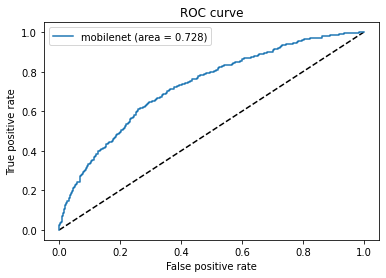

In [14]:
from sklearn import metrics
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(labels, pred)
auc_rf = metrics.auc(fpr_rf, tpr_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='mobilenet (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [30]:
model.save('nih_models/tuned_resnet50.h5')

In [23]:
from tensorflow.keras.models import load_model
model1 = load_model('nih_models/mobilenetv2_update1.h5', custom_objects = {'KerasLayer': hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4")})


In [31]:
model1.evaluate(test_dataset)

50/50 [==============================] - 5s 91ms/step - loss: 0.6613 - accuracy: 0.7031


[0.661299467086792, 0.703125]

In [30]:
model1.evaluate(valid_dataset)

25/25 [==============================] - 2s 90ms/step - loss: 0.6903 - accuracy: 0.6750


[0.6903315186500549, 0.675000011920929]